In [125]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
%matplotlib inline

# 닉네임, 토큰 설정
# os.environ["KAGGLE_USERNAME"] = ''
# os.environ["KAGGLE_KEY"] = ""

# 데이터 받기, colab에서 리눅스 명령어를 사용할때는 앞에 !가 붙습니다.
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [126]:
!unzip -o titanic.zip
!rm titanic.zip
!ls -al

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
total 2172
drwxr-xr-x 8 jovyan users     256 May 21 07:44  .
drwsrwsr-x 1 jovyan users    4096 May 18 10:41  ..
-rw-r--r-- 1 jovyan users    3258 Dec 11  2019  gender_submission.csv
drwxr-xr-x 4 jovyan users     128 May 21 05:49  .ipynb_checkpoints
-rw-r--r-- 1 jovyan users   28629 Dec 11  2019  test.csv
-rw-r--r-- 1 jovyan users 1275563 May 21 07:18  Titanic.ipynb
-rw-r--r-- 1 jovyan users  843150 May 21 07:42 'Titanic Preprocessing.ipynb'
-rw-r--r-- 1 jovyan users   61194 Dec 11  2019  train.csv


In [127]:
df = pd.read_csv('./train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [128]:
df.loc[df['Age'].isnull(), 'Age'] = math.floor(df['Age'].mean())

In [129]:
df.loc[df['Embarked'].isnull(), 'Embarked'] = df['Embarked'].mode()[0]

In [130]:
df['Deck'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search('Z' if pd.isna(x) else x).group())

In [131]:
df['Fare_remainder_by_10'] = df['Fare'] - (df['Fare'] % 10)
df['Age_remainder_by_10'] = df['Age'] - (df['Age'] % 10)

In [132]:
def getNameTitle(name):
    reCom = re.compile("(M(?:is)?s|(?:Mrs?))").search(name)
    if reCom is not None:
        return reCom.group()
    return 'N/A'

In [133]:
df['Name_title'] = df['Name'].map(lambda x: getNameTitle(x))

In [134]:
df['Fare_per_person'] = df['Fare'] / (df['SibSp'] + df['Parch'] + 1)

In [135]:
df['Fare_per_person_remainder_by_10'] = df['Fare_per_person'] - (df['Fare_per_person'] % 10)

In [136]:
df['is_alone'] = 1
df.loc[df['SibSp'] + df['Parch'] > 0, 'is_alone'] = 0

In [137]:
df['is_pclass_3_from_queenstown'] = 0
df.loc[(df['Pclass'] == 3) & (df['Embarked'] == 'Q'), 'is_pclass_3_from_queenstown'] = 1

In [138]:
df['is_pclass_3_from_southampton'] = 0
df.loc[(df['Pclass'] == 3) & (df['Embarked'] == 'S'), 'is_pclass_3_from_southampton'] = 1

In [139]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [140]:
sexDummies = pd.get_dummies(df['Sex'])
embarkedDummies = pd.get_dummies(df['Embarked'])
nameTitleDummies = pd.get_dummies(df['Name_title'])

In [141]:
df = pd.concat([df, sexDummies, embarkedDummies, nameTitleDummies], axis=1)
df = df.drop(['Sex', 'Embarked'], axis=1)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Deck,Fare_remainder_by_10,Age_remainder_by_10,...,female,male,C,Q,S,Miss,Mr,Mrs,Ms,N/A
0,1,0,3,22.0,1,0,7.2500,Z,0.0,20.0,...,0,1,0,0,1,0,1,0,0,0
1,2,1,1,38.0,1,0,71.2833,C,70.0,30.0,...,1,0,1,0,0,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,Z,0.0,20.0,...,1,0,0,0,1,1,0,0,0,0
3,4,1,1,35.0,1,0,53.1000,C,50.0,30.0,...,1,0,0,0,1,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,Z,0.0,30.0,...,0,1,0,0,1,0,1,0,0,0


In [142]:
dfCorr = df.corr()
dfCorr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Fare_remainder_by_10,Age_remainder_by_10,Fare_per_person,...,female,male,C,Q,S,Miss,Mr,Mrs,Ms,N/A
PassengerId,1.000000,-0.005007,-0.035144,0.033632,-0.057527,-0.001652,0.012658,0.012478,0.037231,0.026303,...,-0.042939,0.042939,-0.001205,-0.033606,0.022204,-0.073110,0.040227,0.015864,-0.000261,0.015967
Survived,-0.005007,1.000000,-0.338481,-0.067814,-0.035322,0.081629,0.257307,0.262167,-0.050972,0.221600,...,0.543351,-0.543351,0.168240,0.003650,-0.149683,0.327093,-0.546521,0.344935,0.042470,0.061385
Pclass,-0.035144,-0.338481,1.000000,-0.334974,0.083081,0.018443,-0.549500,-0.564862,-0.339610,-0.485079,...,-0.131900,0.131900,-0.243292,0.221009,0.074053,-0.000576,0.139188,-0.158279,-0.012381,-0.049487
Age,0.033632,-0.067814,-0.334974,1.000000,-0.232978,-0.176486,0.093706,0.096364,0.971893,0.142803,...,-0.082949,0.082949,0.031303,-0.021093,-0.014149,-0.247796,0.187335,0.169894,-0.004024,-0.201989
SibSp,-0.057527,-0.035322,0.083081,-0.232978,1.000000,0.414838,0.159651,0.157098,-0.226973,-0.094682,...,0.114631,-0.114631,-0.059528,-0.026354,0.068734,0.087932,-0.249598,0.062854,-0.015907,0.258425
Parch,-0.001652,0.081629,0.018443,-0.176486,0.414838,1.000000,0.216225,0.220385,-0.158376,-0.068978,...,0.245489,-0.245489,-0.011069,-0.081228,0.060814,0.105567,-0.335107,0.221318,-0.015878,0.179133
Fare,0.012658,0.257307,-0.549500,0.093706,0.159651,0.216225,1.000000,0.998423,0.099775,0.840995,...,0.182333,-0.182333,0.269335,-0.117216,-0.162184,0.118271,-0.182702,0.106104,-0.012961,0.022589
Fare_remainder_by_10,0.012478,0.262167,-0.564862,0.096364,0.157098,0.220385,0.998423,1.000000,0.102177,0.837877,...,0.185802,-0.185802,0.265629,-0.123516,-0.154973,0.119260,-0.187728,0.110161,-0.011038,0.024925
Age_remainder_by_10,0.037231,-0.050972,-0.339610,0.971893,-0.226973,-0.158376,0.099775,0.102177,1.000000,0.142494,...,-0.074794,0.074794,0.030254,-0.063081,0.013193,-0.231243,0.161095,0.162347,-0.010408,-0.166395
Fare_per_person,0.026303,0.221600,-0.485079,0.142803,-0.094682,-0.068978,0.840995,0.837877,0.142494,1.000000,...,0.115143,-0.115143,0.271215,-0.096038,-0.177159,0.112059,-0.083972,0.013375,-0.006472,-0.032031


<AxesSubplot:>

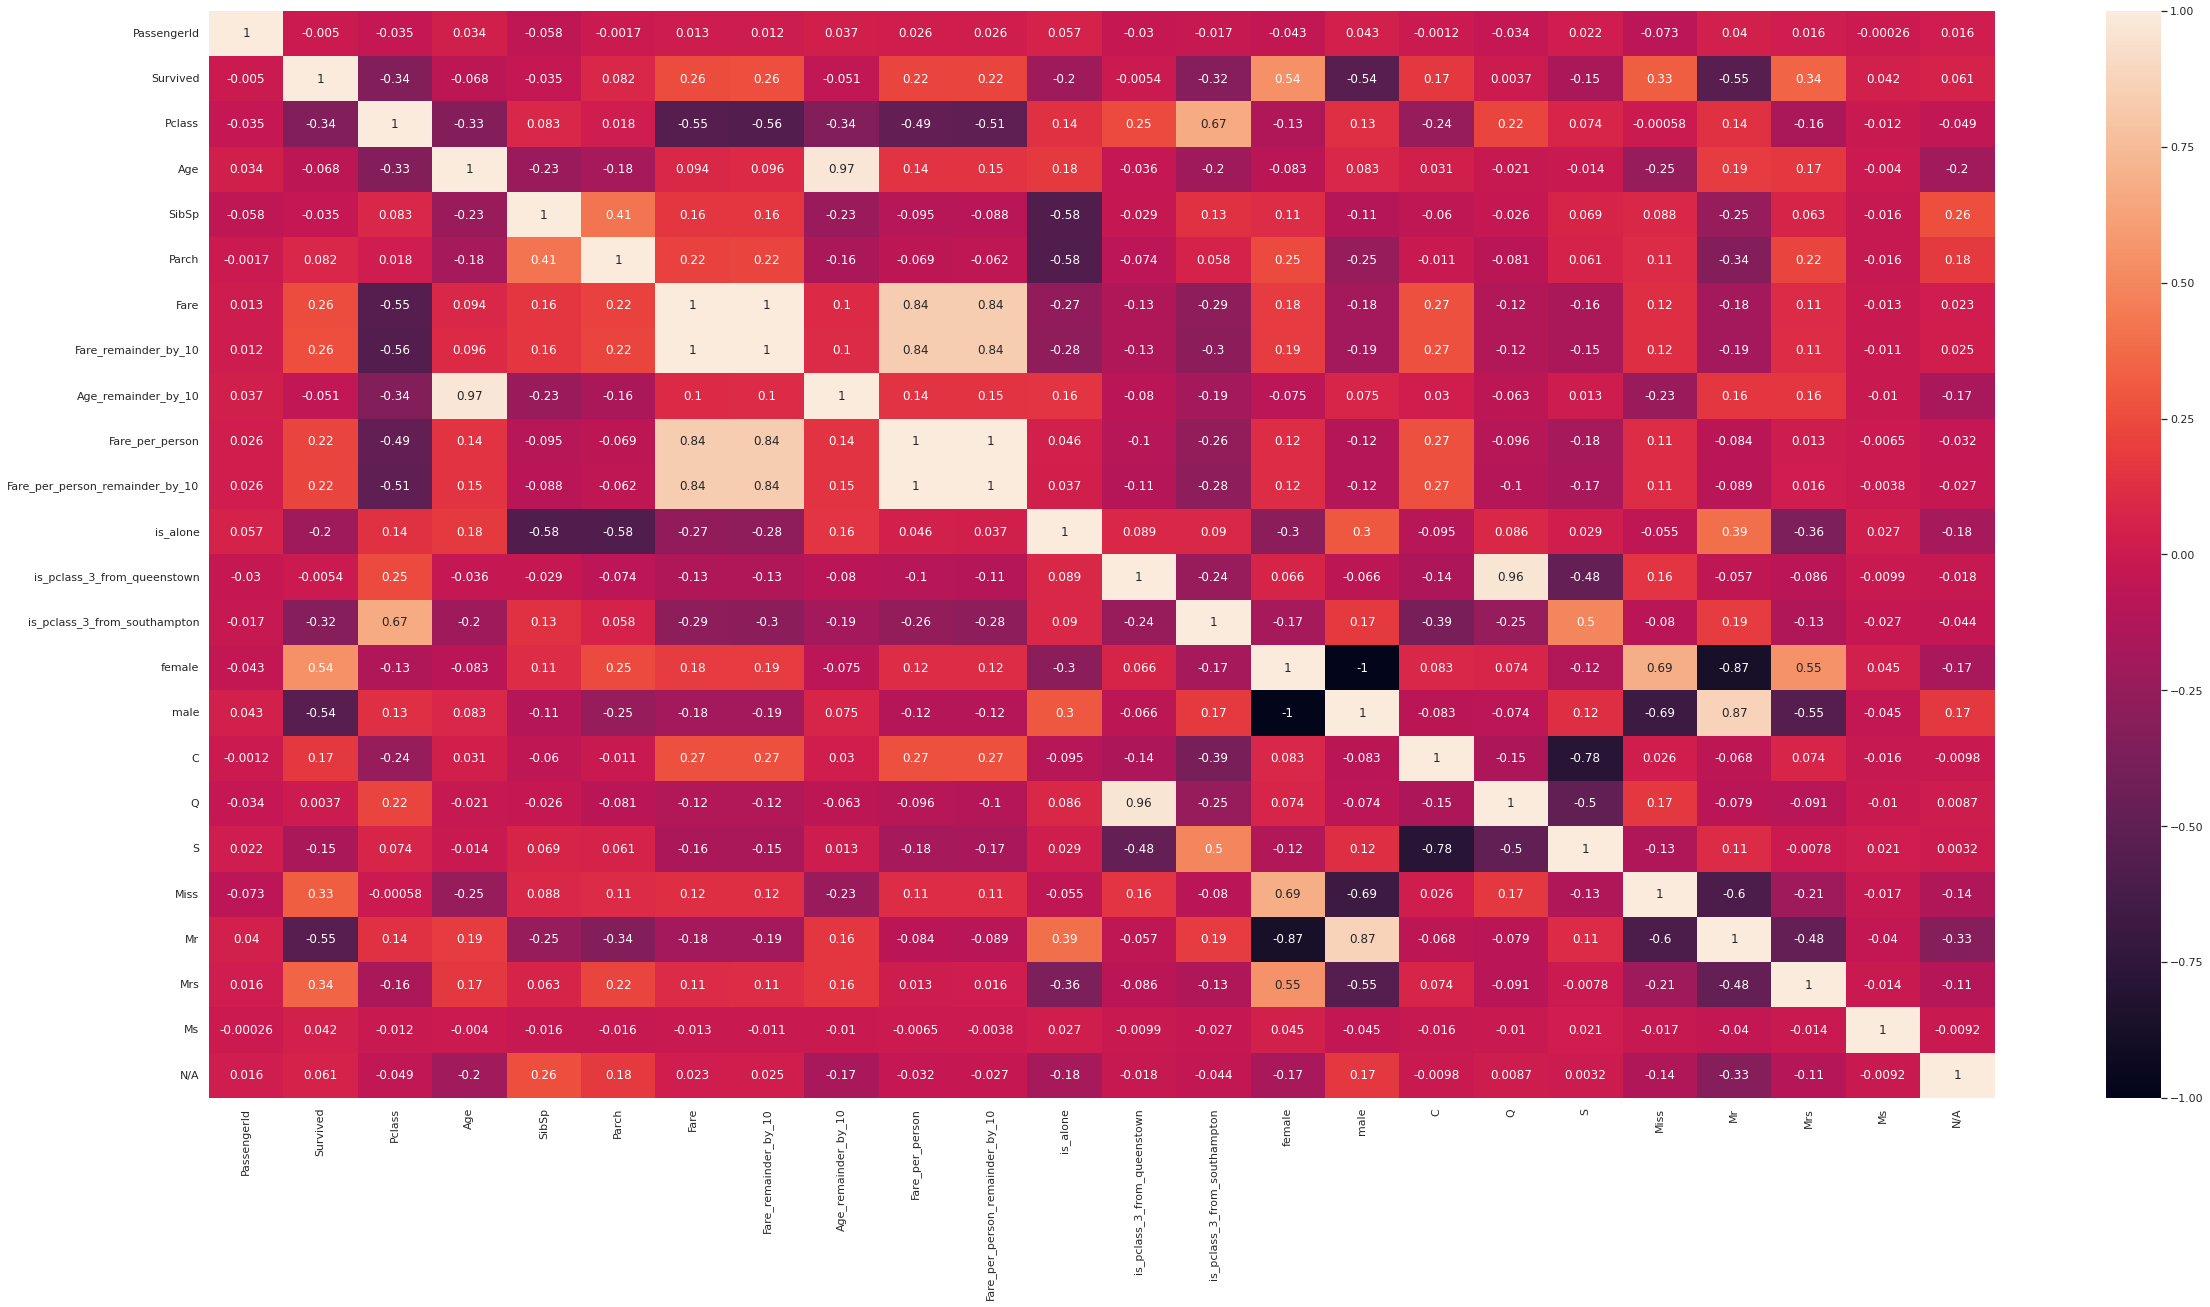

In [145]:
sns.set(rc = {'figure.figsize':(40,20)})
sns.heatmap(dfCorr, annot=True)

In [146]:
dfFiltered = df[['Survived', 'Pclass', 'Fare', 'Fare_per_person', 'is_alone', 'is_pclass_3_from_southampton', 'female', 'male', 'C', 'S', 'Mr', 'Mrs', 'Miss']]
dfFiltered

,Survived,Pclass,Fare,Fare_per_person,is_alone,is_pclass_3_from_southampton,female,male,C,S,Mr,Mrs,Miss
0,0,3,7.2500,3.62500,0,1,0,1,0,1,1,0,0
1,1,1,71.2833,35.64165,0,0,1,0,1,0,0,1,0
2,1,3,7.9250,7.92500,1,1,1,0,0,1,0,0,1
3,1,1,53.1000,26.55000,0,0,1,0,0,1,0,1,0
4,0,3,8.0500,8.05000,1,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,13.0000,13.00000,1,0,0,1,0,1,0,0,0
887,1,1,30.0000,30.00000,1,0,1,0,0,1,0,0,1
888,0,3,23.4500,5.86250,0,1,1,0,0,1,0,0,1
889,1,1,30.0000,30.00000,1,0,0,1,1,0,1,0,0


In [147]:
dfFilteredCorr = dfFiltered.corr()
dfFilteredCorr

,Survived,Pclass,Fare,Fare_per_person,is_alone,is_pclass_3_from_southampton,female,male,C,S,Mr,Mrs,Miss
Survived,1.000000,-0.338481,0.257307,0.221600,-0.203367,-0.323190,0.543351,-0.543351,0.168240,-0.149683,-0.546521,0.344935,0.327093
Pclass,-0.338481,1.000000,-0.549500,-0.485079,0.135207,0.670193,-0.131900,0.131900,-0.243292,0.074053,0.139188,-0.158279,-0.000576
Fare,0.257307,-0.549500,1.000000,0.840995,-0.271832,-0.286397,0.182333,-0.182333,0.269335,-0.162184,-0.182702,0.106104,0.118271
Fare_per_person,0.221600,-0.485079,0.840995,1.000000,0.045603,-0.262183,0.115143,-0.115143,0.271215,-0.177159,-0.083972,0.013375,0.112059
is_alone,-0.203367,0.135207,-0.271832,0.045603,1.000000,0.090266,-0.303646,0.303646,-0.095298,0.029074,0.394266,-0.364387,-0.055127
is_pclass_3_from_southampton,-0.323190,0.670193,-0.286397,-0.262183,0.090266,1.000000,-0.174851,0.174851,-0.390465,0.498842,0.185016,-0.133345,-0.080284
female,0.543351,-0.131900,0.182333,0.115143,-0.303646,-0.174851,1.000000,-1.000000,0.082853,-0.119224,-0.869335,0.552686,0.686808
male,-0.543351,0.131900,-0.182333,-0.115143,0.303646,0.174851,-1.000000,1.000000,-0.082853,0.119224,0.869335,-0.552686,-0.686808
C,0.168240,-0.243292,0.269335,0.271215,-0.095298,-0.390465,0.082853,-0.082853,1.000000,-0.782742,-0.067875,0.074309,0.026215
S,-0.149683,0.074053,-0.162184,-0.177159,0.029074,0.498842,-0.119224,0.119224,-0.782742,1.000000,0.109217,-0.007755,-0.130650


<AxesSubplot:>

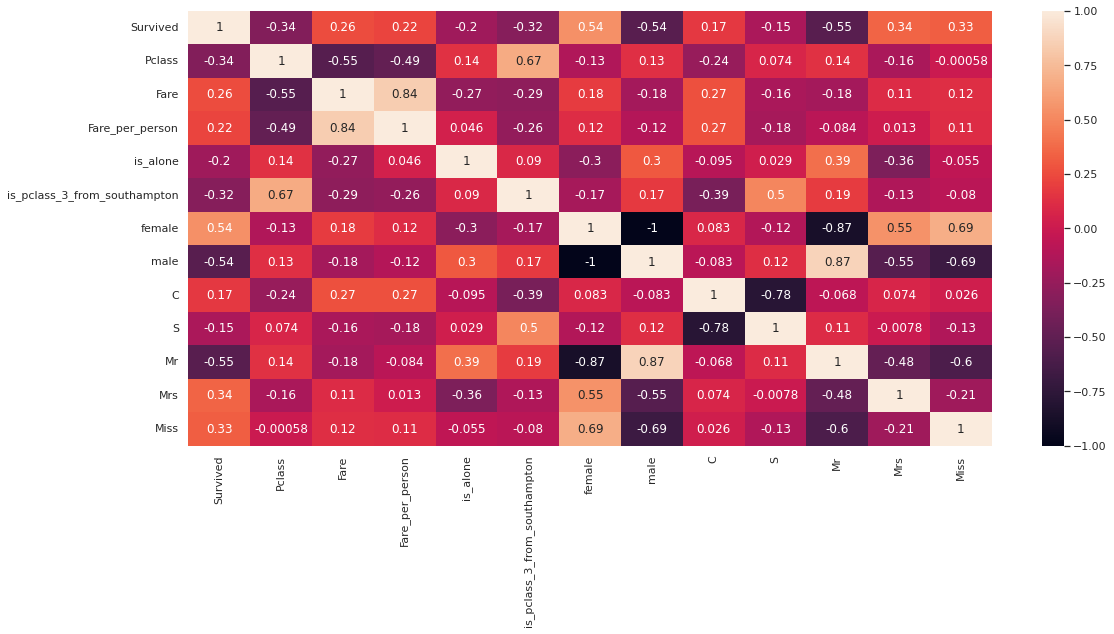

In [149]:
sns.set(rc = {'figure.figsize':(18,8)})
sns.heatmap(dfFilteredCorr, annot=True)

In [150]:
dfFiltered.describe()

,Survived,Pclass,Fare,Fare_per_person,is_alone,is_pclass_3_from_southampton,female,male,C,S,Mr,Mrs,Miss
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,32.204208,19.916375,0.602694,0.396184,0.352413,0.647587,0.188552,0.725028,0.581369,0.142536,0.204265
std,0.486592,0.836071,49.693429,35.841257,0.489615,0.489378,0.477990,0.477990,0.391372,0.446751,0.493612,0.349796,0.403390
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,7.910400,7.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,14.454200,8.300000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,31.000000,23.666667,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,3.000000,512.329200,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [151]:
Y = dfFiltered['Survived']
X = dfFiltered[['Pclass', 'Fare', 'Fare_per_person', 'is_alone', 'is_pclass_3_from_southampton', 'female', 'male', 'C', 'S', 'Mr', 'Mrs', 'Miss']]

In [152]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [153]:
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=5)

In [154]:
decisionTree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

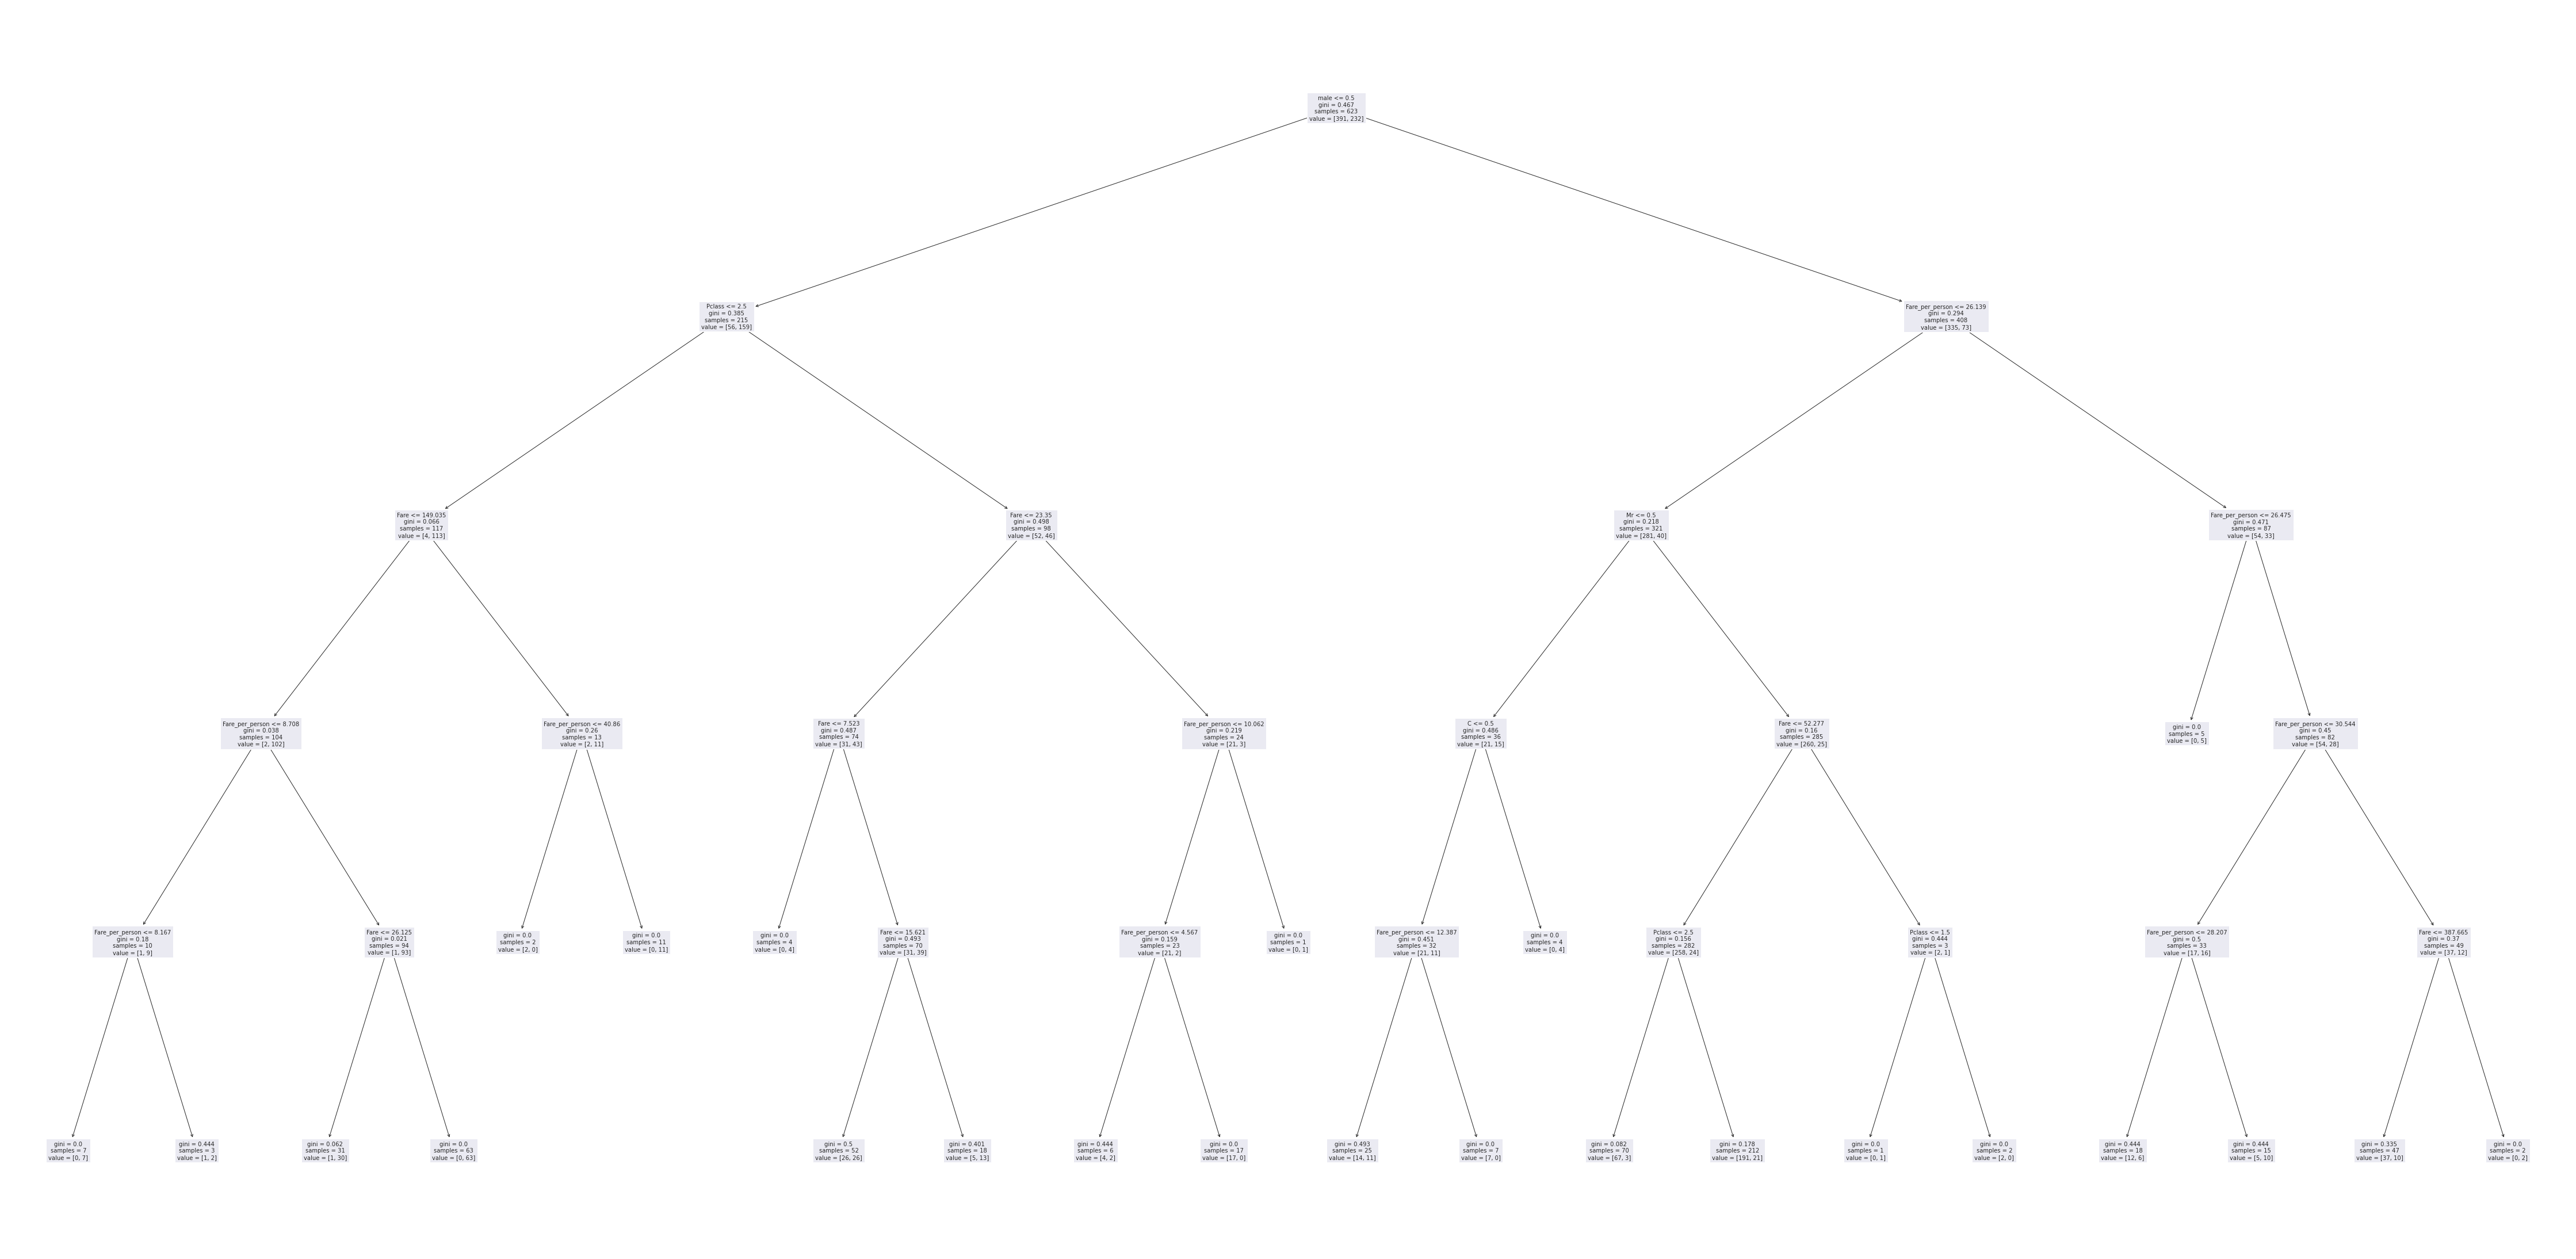

In [156]:
plt.figure(figsize=(80, 40))
plot_tree(decisionTree, fontsize=10, feature_names=['Pclass', 'Fare', 'Fare_per_person', 'is_alone', 'is_pclass_3_from_southampton', 'female', 'male', 'C', 'S', 'Mr', 'Mrs', 'Miss'])
plt.show()

In [157]:
decisionTree.score(x_train, y_train)

0.8539325842696629

In [158]:
decisionTree.score(x_test, y_test)

0.7761194029850746

In [169]:
df_test = pd.read_csv('./test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [170]:
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = math.floor(df_test['Fare'].mean())

In [171]:
df_test.loc[df_test['Age'].isnull(), 'Age'] = math.floor(df_test['Age'].mean())
df_test.loc[df_test['Embarked'].isnull(), 'Embarked'] = df_test['Embarked'].mode()[0]
df_test['Deck'] = df_test['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search('Z' if pd.isna(x) else x).group())
df_test['Fare_remainder_by_10'] = df_test['Fare'] - (df_test['Fare'] % 10)
df_test['Age_remainder_by_10'] = df_test['Age'] - (df_test['Age'] % 10)
df_test['Name_title'] = df_test['Name'].map(lambda x: getNameTitle(x))
df_test['Fare_per_person'] = df_test['Fare'] / (df_test['SibSp'] + df_test['Parch'] + 1)
df_test['Fare_per_person_remainder_by_10'] = df_test['Fare_per_person'] - (df_test['Fare_per_person'] % 10)
df_test['is_alone'] = 1
df_test.loc[df_test['SibSp'] + df_test['Parch'] > 0, 'is_alone'] = 0
df_test['is_pclass_3_from_queenstown'] = 0
df_test.loc[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'Q'), 'is_pclass_3_from_queenstown'] = 1
df_test['is_pclass_3_from_southampton'] = 0
df_test.loc[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'S'), 'is_pclass_3_from_southampton'] = 1
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
sexDummies = pd.get_dummies(df_test['Sex'])
embarkedDummies = pd.get_dummies(df_test['Embarked'])
nameTitleDummies = pd.get_dummies(df_test['Name_title'])
df_test = pd.concat([df_test, sexDummies, embarkedDummies, nameTitleDummies], axis=1)
df_test = df_test.drop(['Sex', 'Embarked'], axis=1)

In [172]:
df_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Deck,Fare_remainder_by_10,Age_remainder_by_10,Name_title,...,female,male,C,Q,S,Miss,Mr,Mrs,Ms,N/A
0,892,3,34.5,0,0,7.8292,Z,0.0,30.0,Mr,...,0,1,0,1,0,0,1,0,0,0
1,893,3,47.0,1,0,7.0000,Z,0.0,40.0,Mrs,...,1,0,0,0,1,0,0,1,0,0
2,894,2,62.0,0,0,9.6875,Z,0.0,60.0,Mr,...,0,1,0,1,0,0,1,0,0,0
3,895,3,27.0,0,0,8.6625,Z,0.0,20.0,Mr,...,0,1,0,0,1,0,1,0,0,0
4,896,3,22.0,1,1,12.2875,Z,10.0,20.0,Mrs,...,1,0,0,0,1,0,0,1,0,0


In [173]:
df_testFiltered = df_test[['Pclass', 'Fare', 'Fare_per_person', 'is_alone', 'is_pclass_3_from_southampton', 'female', 'male', 'C', 'S', 'Mr', 'Mrs', 'Miss']]
df_testFiltered

,Pclass,Fare,Fare_per_person,is_alone,is_pclass_3_from_southampton,female,male,C,S,Mr,Mrs,Miss
0,3,7.8292,7.829200,1,0,0,1,0,0,1,0,0
1,3,7.0000,3.500000,0,1,1,0,0,1,0,1,0
2,2,9.6875,9.687500,1,0,0,1,0,0,1,0,0
3,3,8.6625,8.662500,1,1,0,1,0,1,1,0,0
4,3,12.2875,4.095833,0,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,8.0500,8.050000,1,1,0,1,0,1,1,0,0
414,1,108.9000,108.900000,1,0,1,0,1,0,0,0,0
415,3,7.2500,7.250000,1,1,0,1,0,1,1,0,0
416,3,8.0500,8.050000,1,1,0,1,0,1,1,0,0


In [174]:
df_testFiltered.isna().sum()

Pclass                          0
Fare                            0
Fare_per_person                 0
is_alone                        0
is_pclass_3_from_southampton    0
female                          0
male                            0
C                               0
S                               0
Mr                              0
Mrs                             0
Miss                            0
dtype: int64

In [190]:
predictResult = decisionTree.predict(df_testFiltered)

In [191]:
predictResult = pd.DataFrame(predictResult, columns = ['Survived'])
predictResult.head()

,Survived
0,0
1,1
2,0
3,0
4,0


In [194]:
predictDf = pd.concat([df_test['PassengerId'], predictResult['Survived']], axis=1)
predictDf.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [195]:
predictDf.to_csv('./submission.csv', sep=',', index = False)

In [196]:
!kaggle competitions submit -c titanic -f submission.csv -m "Decision tree"

100%|████████████████████████████████████████| 2.77k/2.77k [00:03<00:00, 795B/s]
Successfully submitted to Titanic - Machine Learning from Disaster